In [22]:
# Imports

# File handling
import os
import cv2
import splitfolders

# Visualization
import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NumPy
import numpy as np

# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from keras import layers
from keras.callbacks import CSVLogger
from keras.utils import image_dataset_from_directory
from keras.regularizers import l2

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report

## Utility functions

In [2]:
def load_model(file="model18.h5", hist="18_history.csv"):
    
    # load model and history
    
    import tensorflow as tf
    import pandas as pd
    import numpy as np
    model = tf.keras.models.load_model(file)
    history = pd.read_csv(hist)[['loss','binary_accuracy', 'val_loss', 'val_binary_accuracy']]
    return model, history

def get_data(train_path='images/train/', test_path='images/test/', valid_path='images/val/', size=(256, 256), batch_size=1):
    
    # preprocess train, test and valid sets
    
    from keras.utils import image_dataset_from_directory
    train = image_dataset_from_directory(directory=train_path,
                             label_mode='binary',
                             color_mode="rgb",
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=True,
                             seed=77)
    test = image_dataset_from_directory(directory=test_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=False,
                             seed=77)
    valid = image_dataset_from_directory(directory=valid_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=False,
                             seed=77)
    return train, test, valid

def evaluate_model(model, n, valid, test):
    
    pd.DataFrame(model.history.history).plot(figsize=(15,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(f'Model {n} Learning Curves')
    plt.show()
    print()
    print()
    print()
    print('Test set score')
    print()
    model.evaluate(test)
    print()
    print()
    print()
    print('Validation set score')
    print()
    model.evaluate(valid)

def dim_info(dimension):
    print("Dimension type: ", type(dimension))
    print("Dimension length: ", len(dimension))

def images_to_arrays(folder_path):
    X = []
    y = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        class_label = class_folder  # Assign the class folder name as the label
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (256, 256))  # Resize the image
                img_array = np.array(img, dtype=np.float32)  # Convert array values to float
                X.append(img_array)
                y.append(class_label)
    return np.array(X), np.array(y)

In [6]:
# model
model = load_model()[0]
weights = model.get_weights()

## Model

In [107]:
# data
train, test, valid = get_data()

Found 16930 files belonging to 2 classes.
Found 2120 files belonging to 2 classes.
Found 2115 files belonging to 2 classes.


In [6]:
# cnn
shape = (256, 256, 3)
drop = 0.6
kernel = (3, 3)
pool = (2, 2)
num_classes=2
regularizer=l2(0.01)
learning_rate=0.0017

model18 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model18.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model18.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

Epoch 1/50
530/530 [==============================] - 146s 274ms/step - loss: 0.5872 - binary_accuracy: 0.7271 - val_loss: 0.4648 - val_binary_accuracy: 0.7948
Epoch 2/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4833 - binary_accuracy: 0.7856 - val_loss: 0.4433 - val_binary_accuracy: 0.8024
Epoch 3/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4585 - binary_accuracy: 0.8004 - val_loss: 0.4319 - val_binary_accuracy: 0.8076
Epoch 4/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4545 - binary_accuracy: 0.8058 - val_loss: 0.4077 - val_binary_accuracy: 0.8213
Epoch 5/50
530/530 [==============================] - 144s 272ms/step - loss: 0.4440 - binary_accuracy: 0.8108 - val_loss: 0.4301 - val_binary_accuracy: 0.8165
Epoch 6/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4358 - binary_accuracy: 0.8151 - val_loss: 0.4100 - val_binary_accuracy: 0.8265
Epoch 7/50
530/530 [====================

In [135]:
model18.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

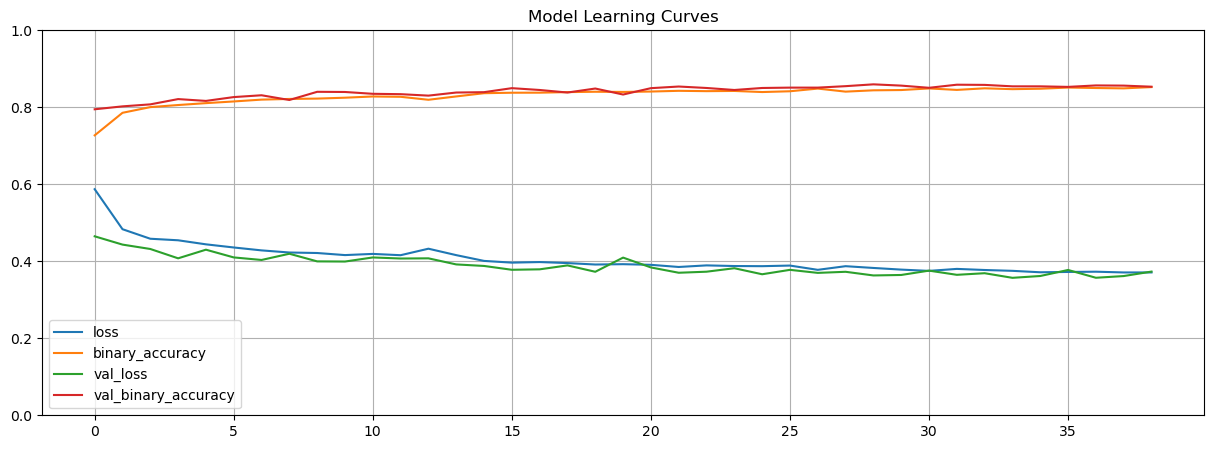




Test set score

67/67 [==============================] - 5s 75ms/step - loss: 0.3481 - binary_accuracy: 0.8656



Validation set score

67/67 [==============================] - 5s 74ms/step - loss: 0.3570 - binary_accuracy: 0.8544


In [76]:
evaluate_model(model18)

In [31]:
pred = model.predict(X_test).round()

67/67 [==============================] - 4s 62ms/step


<Axes: >

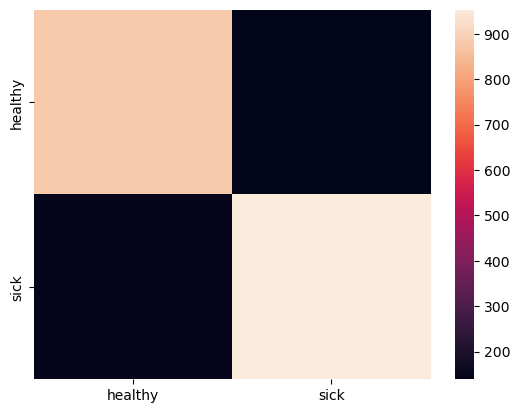

In [37]:
sns.heatmap(confusion_matrix(y_test, pred), yticklabels=['healthy', 'sick'], xticklabels=['healthy', 'sick'])

In [34]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      1020
         1.0       0.87      0.87      0.87      1100

    accuracy                           0.87      2120
   macro avg       0.86      0.87      0.86      2120
weighted avg       0.87      0.87      0.87      2120



## Other classification Models

In [39]:
# comparison models data preprocessing
X_train, y_train = images_to_arrays("images\\train")
y_train[y_train == 'healthy'] = 0
y_train[y_train == 'sick'] = 1
y_train = y_train.astype('float32')

X_test, y_test = images_to_arrays("images\\test")
y_test[y_test == 'healthy'] = 0
y_test[y_test == 'sick'] = 1
y_test = y_test.astype('float32')

# data input for logreg and knn
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [44]:
# logistic regression classifier
logreg = LogisticRegression(max_iter=50)
logreg.fit(X_train_flat, y_train)
y_pred_logreg = logreg.predict(X_test_flat)
print("Logistic Regression Classifier accuracy: ", logreg.score(X_test_flat, y_test))

Logistic Regression Classifier accuracy:  0.8160377358490566


<Axes: >

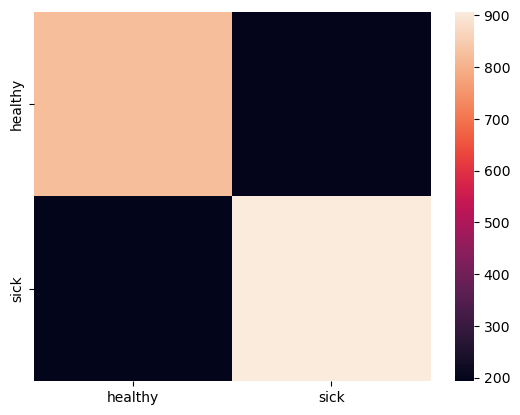

In [41]:
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), yticklabels=['healthy', 'sick'], xticklabels=['healthy', 'sick'])

In [43]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      1020
         1.0       0.82      0.82      0.82      1100

    accuracy                           0.82      2120
   macro avg       0.82      0.82      0.82      2120
weighted avg       0.82      0.82      0.82      2120



In [45]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_flat, y_train)
y_pred_knn = knn.predict(X_test_flat)
print("K-Nearest-Neighbour Classifier accuracy: ", accuracy_score(y_test, y_pred_knn))

K-Nearest-Neighbour Classifier accuracy:  0.8537735849056604


<Axes: >

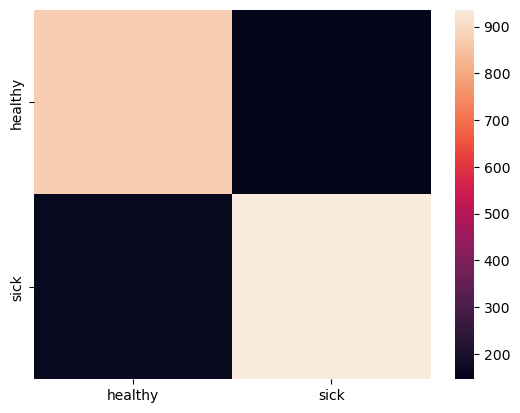

In [46]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), yticklabels=['healthy', 'sick'], xticklabels=['healthy', 'sick'])

In [47]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      1020
         1.0       0.87      0.85      0.86      1100

    accuracy                           0.85      2120
   macro avg       0.85      0.85      0.85      2120
weighted avg       0.85      0.85      0.85      2120

